In [1]:
# HINTS with numpy
#%load_ext line_profiler
import numpy as np
from HINTS import *
from HINTS_fn import *


In [2]:
# NB the proposed state must not share memory with the original state (because we hash when we cache)
def proposal1(state, index):
    return(state + 0.1 * randn(state.shape[0]), 0.0) # new state, optional evaluation at new state, correction for asymmetry  



In [3]:
# test the  Test function
xs = np.arange(-2.0, 2.0, 0.001)
shuffle(xs) # so noise is random

exs = np.expand_dims(xs, axis=1)
print(exs.shape)

e = TestFn(proposal1, xs.size)



(4000, 1)


In [4]:

%time ys = [e.evaluate(x, i) for i, x in enumerate(exs)]
#print(cache.stats(enable=True))
%time ys = [e.evaluate(x, i) for i, x in enumerate(exs)]
#%time ys = [e.cached_evaluate(x, i) for i, x in enumerate(exs)]
#print(cache.stats(enable=True))
#%time ys = [e.user_evaluate(x, i) for i, x in enumerate(exs)]
#print(cache.stats(enable=True))

# caching has a big overhead!!


CPU times: user 134 ms, sys: 3.85 ms, total: 138 ms
Wall time: 137 ms
CPU times: user 3.35 ms, sys: 0 ns, total: 3.35 ms
Wall time: 3.36 ms


In [5]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0] # defaults
#HINTS payoff comes for large num scenarios > 1000
# checked regular MCMC is accurate (1 level, lbf = 6)
if True:
    args.levels = 5
    log_branch_factor = 2
    N_0 = 1
    args.design = np.array([N_0] + [2 ** log_branch_factor for l in range(args.levels)])
    NUM_SCENARIOS = N_0 * 2 ** (args.levels * log_branch_factor) # TO DO get from HINTS
    iterations = 5000
else: #MCMC
    args.levels = 0
    NUM_SCENARIOS = 1024
    args.design = np.array([NUM_SCENARIOS])
    iterations = 42094# need to match actual evaluations

print(NUM_SCENARIOS)

# design now has levels + 1 entries

# additive log probability is more natural from a Bayesian perspective but both are valid

args.additive = True # effectively selects a different temperature structure when False (= average or expectation)

args.T = 1.0 #top level
args.dT = 0.0 if args.additive else 0.5 # temperature increment by level (mainly for optimisation or averaging structure)

print(args.__dict__)

1024
{'levels': 5, 'design': array([1, 4, 4, 4, 4, 4]), 'additive': True, 'T': 1.0, 'dT': 0.0}


In [6]:

g = TestFn(proposal1, NUM_SCENARIOS, args.additive)
hmc = HINTS(args, g)
state  = g.sample_initial_state()
print(state)

nsd = 4.0 # for diagnostics only
bins = 64

histogram = np.zeros([bins], dtype = float)

#%timeit hmc.shuffle() # negligible
#%timeit hmc.hints(state,  levels, index = 0, T = 1.0, dbg = False) # e.g. dbg = (t==0)




RESET
5
[   1    4   16   64  256 1024]
1024
[1. 1. 1. 1. 1. 1.]
[0.14138998]


In [7]:
# FAR FASTER WITHOUT CACHING FOR SIMPLE TEST TASKS
# SO IF WE CACHE, SHOULD BE BIG CHUNKS. OR WE AVOID MEMOIZING
# e.g. JUST KEEP LUT PER STATE (i.e. at each level)

#cache.clear()
#print(cache.stats(enable=True, reset = True))
for t in range(iterations):
    hmc.shuffle()
    state, correction = hmc.hints(state, args.levels) # e.g. dbg = (t==0)
    # diagnostic histogram
    if (abs(state[0]) < nsd): # ignoring samples outside diagnostic range
        j = int((state[0] + nsd) * bins/(2.0 * nsd))
        histogram[j] += 1.0
    # show progress
    if ((t%500)==499):
        print(t+1, hmc.acceptances, hmc.rejections)
        #print(cache.stats(enable=True, reset = True))


500 [511974 127952  31912   7788   1641    316] [ 26  48  88 212 359 184]
1000 [1023949  255895   63821   15571    3314     631] [ 51 105 179 429 686 369]
1500 [1535910  383844   95714   23376    4975     935] [  90  156  286  624 1025  565]
2000 [2047869  511803  127624   31188    6660    1241] [ 131  197  376  812 1340  759]
2500 [2559842  639764  159514   38990    8334    1564] [ 158  236  486 1010 1666  936]
3000 [3071818  767715  191411   46778   10013    1876] [ 182  285  589 1222 1987 1124]
3500 [3583780  895672  223321   54551   11721    2198] [ 220  328  679 1449 2279 1302]
4000 [4095750 1023625  255225   62338   13392    2520] [ 250  375  775 1662 2608 1480]
4500 [4607715 1151563  287133   70129   15068    2837] [ 285  437  867 1871 2932 1663]
5000 [5119676 1279508  319040   77905   16729    3152] [ 324  492  960 2095 3271 1848]


In [8]:
print(histogram)
print(hmc.acceptances)
print(hmc.rejections)
print(hmc.acceptances / (hmc.acceptances + hmc.rejections))

[  0.   0.   0.   0.   1.   1.   1.   4.   3.   3.  13.   7.  13.  19.
  24.  22.  40.  76.  75.  45.  92.  85. 127. 144. 165. 177. 188. 239.
 248. 202. 239. 244. 288. 246. 217. 224. 201. 193. 176. 183. 127. 135.
 103.  94.  75.  62.  33.  34.  34.  18.  22.  12.   6.   7.   2.   1.
   3.   0.   4.   1.   0.   0.   0.   0.]
[5119676 1279508  319040   77905   16729    3152]
[ 324  492  960 2095 3271 1848]
[0.99993672 0.99961563 0.997      0.9738125  0.83645    0.6304    ]


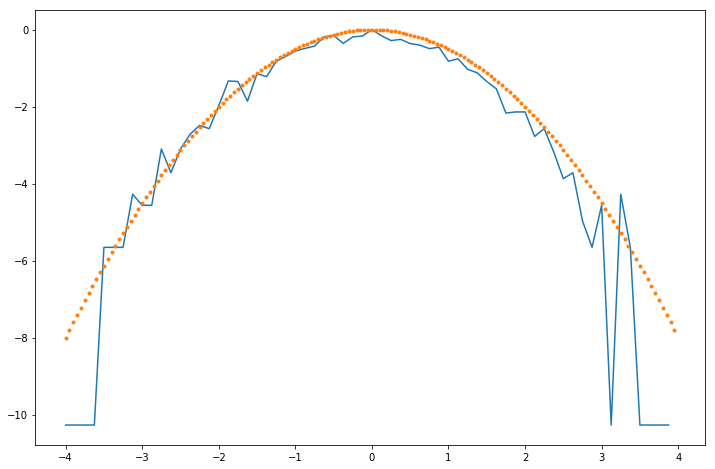

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt # just for testing

#plt.plot(histogram)
fig = plt.figure(figsize=[12,8])
ax1 = plt.gca()
xs1 = np.arange(bins, dtype = float) * (2.0 * nsd)/bins - nsd 

logprob = np.log(histogram + 0.01)

plt.plot(xs1, logprob - np.max(logprob))
xs = np.arange(-nsd, nsd, nsd/80.0)
shuffle(xs) # so noise is not correlated with term
exs = np.expand_dims(xs, axis=1)

#hxs = [HashableItem(np.array([x])) for x in xs]

# do not create a new test function here... use the same one
if args.additive:
    ys = [sum([g.evaluate(x, i) for i in range(NUM_SCENARIOS)]) for x in exs]
else:
    ys = [sum([g.evaluate(x, i)/NUM_SCENARIOS for i in range(NUM_SCENARIOS)]) for x in exs]

plt.plot(xs, ys,'.')


In [15]:
print('Calls: {:,}; '.format(g.total_counter) + 'Missed cache: {:,}; '.format(g.counter) + 'Miss rate: {}%'.format(int((100.0 * g.counter)/g.total_counter)))
# HINTS gives you fewwer samples but each is better mixed
# which is fine if you are going to marginalise 


Calls: 61,440,000; Missed cache: 43,112,765; Miss rate: 70%


In [11]:
#iterations = int(g.counter/NUM_SCENARIOS) # for MCMC
iterations = int(43104413/NUM_SCENARIOS) # for MCMC
iterations

42094

In [12]:
# example of how to use line profiler
if False:
    from line_profiler import LineProfiler
    lp = LineProfiler()
    lp.add_function(g.__call__)
    lp.add_function(g.cached_evaluate)
    lp_wrapper = lp(hmc.hints)
    lp_wrapper(state, args.levels)
    #lp_wrapper = lp(g.evaluate)
    #lp_wrapper(np.array([0.123456789]), args.levels)
    lp.print_stats()



In [13]:
# TO DO 
# pytorch test function
# state is model
# proposal is grad descent + noise (Langevin or HMC style) on minibatch
# SEE TorchModelScratch